In [1]:
%matplotlib inline
import os.path as op
from glob import glob
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
classes = ['accepted', 'ignored', 'rejected']
ign_codes = ['I005', 'I007', 'I010', 'I011']
rej_codes = ['I002', 'I003', 'I004', 'I006', 'I008', 'I009']
all_codes = sorted(ign_codes + rej_codes)

base_dir = '/scratch/tsalo006/reliability_analysis/tedana_outputs/'

In [3]:
columns = ['label', 'failure', 'duration', 'accepted', 'rejected', 'ignored'] + all_codes
summary_df = pd.DataFrame(columns=columns)

ted_dirs = sorted(glob(op.join(base_dir, 'logging-seed*')))
comptables = sorted(glob(op.join(base_dir, 'sub-*_seed-*_comptable.txt')))
labels = [op.basename(c) for c in comptables]
labels = [c.replace('_comptable.txt', '') for c in labels]

for label in labels:
    sub, seed = label.split('_')
    seed = seed.split('-')[-1]
    comptable = pd.read_csv(
        op.join(base_dir, '{0}_seed-{1}_comptable.txt'.format(sub, seed)), sep='\t')

    log_df = pd.read_csv(op.join(base_dir, '{0}_seed-{1}_log.tsv'.format(sub, seed)),
                         sep='\t', header=None,
                         names=['time', 'module', 'level', 'message'])
    log_df['time'] = pd.to_datetime(log_df['time'])
    duration = log_df['time'].iloc[-1] - log_df['time'].iloc[0]
    minutes = duration.total_seconds() / 60.
    failure = any(log_df['message'].str.contains('ICA failed to converge'))
    rationales = comptable['rationale'].tolist()
    classifications = comptable['classification'].tolist()
    rationales = [[m for m in r.split(';') if m] for r in rationales if isinstance(r, str)]
    rationales = [item for sublist in rationales for item in sublist]
    counter = dict(Counter(rationales))
    counter['subject'] = sub
    counter['seed'] = seed

    counter2 = dict(Counter(classifications))
    for k, v in counter2.items():
        counter[k] = v

    counter['failure'] = failure
    counter['duration'] = minutes
    summary_df = summary_df.append(counter, ignore_index=True).fillna(0)

In [4]:
summary_df.head()

,label,failure,duration,accepted,rejected,ignored,I002,I003,I004,I005,...,S0 dice is higher than R2 dice and high variance explained,candartA,candartB,ign_add0,low variance,midk,seed,signal-noise_t < 0 and high variance explained,subject,ign_add1
0,0.0,False,17.066667,44,129,200,0.0,0.0,0.0,0.0,...,51.0,4.0,3.0,3.0,197.0,1.0,000,60.0,sub-01,0.0
1,0.0,False,16.666667,39,135,199,0.0,0.0,0.0,0.0,...,52.0,4.0,4.0,3.0,196.0,1.0,001,66.0,sub-01,0.0
2,0.0,False,17.316667,36,131,206,0.0,0.0,0.0,0.0,...,53.0,4.0,5.0,3.0,203.0,2.0,002,50.0,sub-01,1.0
3,0.0,False,17.383333,44,130,199,0.0,0.0,0.0,0.0,...,50.0,5.0,5.0,3.0,196.0,2.0,003,58.0,sub-01,0.0
4,0.0,False,16.566667,40,127,206,0.0,0.0,0.0,0.0,...,54.0,6.0,5.0,6.0,200.0,2.0,004,51.0,sub-01,1.0


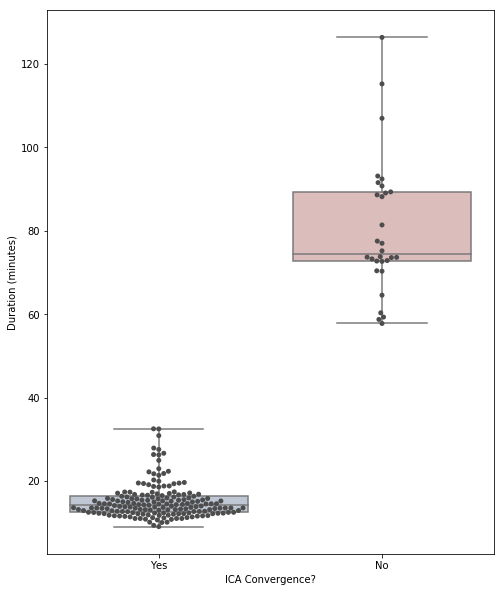

In [5]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="failure", y="duration", data=summary_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="failure", y="duration", data=summary_df,
              color=".3", linewidth=0)

ax.set_ylabel('Duration (minutes)')
ax.set_xlabel('ICA Convergence?')
ax.set_xticklabels(['Yes', 'No'])
fig.savefig('run_duration_by_convergence.png')

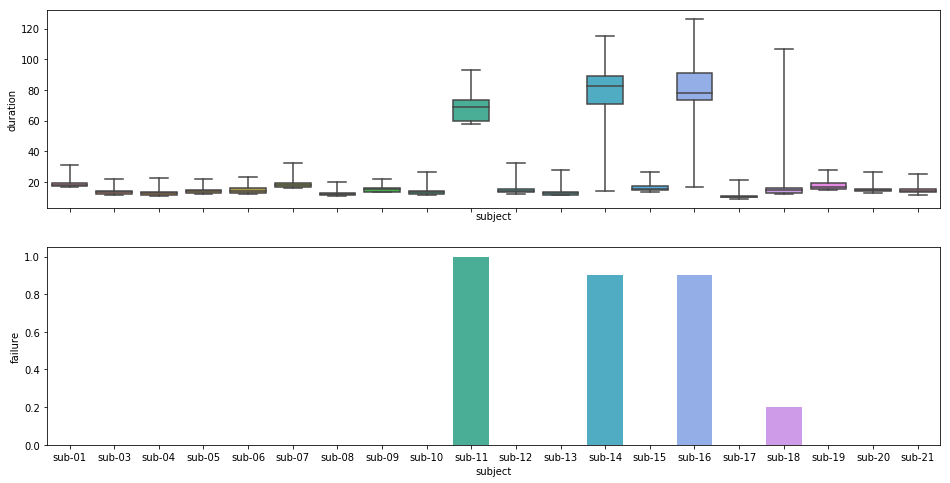

In [6]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(16, 8))
sns.boxplot(x="subject", y="duration", data=summary_df,
            whis="range", ax=axes[0])

temp_df = summary_df.groupby('subject').mean()
temp_df['subject'] = temp_df.index
sns.barplot(x="subject", y="failure", data=temp_df,
            ax=axes[1])
fig.savefig('run_duration_by_subject.png')

/home/data/nbc/data-analysis/env3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


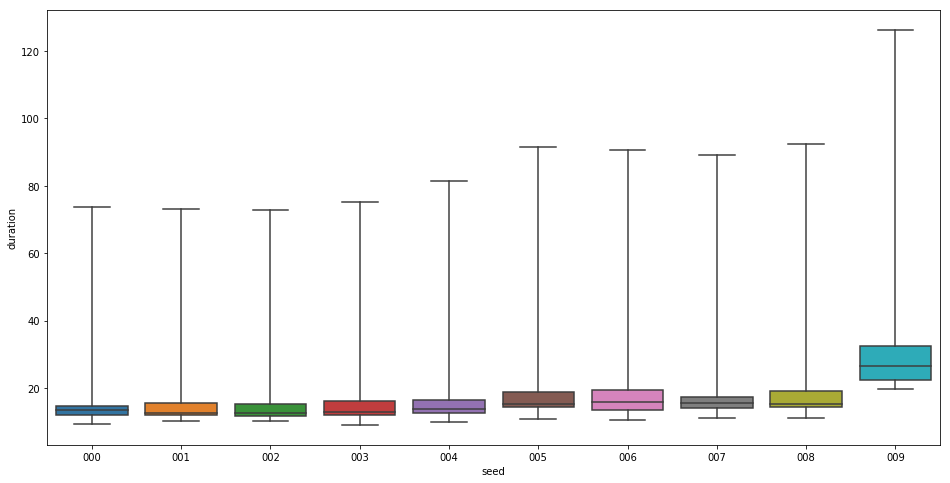

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="seed", y="duration", data=summary_df,
            whis="range", ax=ax)
fig.show()

In [8]:
clf_df = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label', 'failure'])
clf_df2 = summary_df.melt(value_vars=['accepted', 'rejected', 'ignored'],
                         var_name='classification', value_name='n components',
                         id_vars=['label'])
clf_df2['failure'] = 'Total'
df2 = pd.concat((clf_df, clf_df2))

/home/data/nbc/data-analysis/env3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


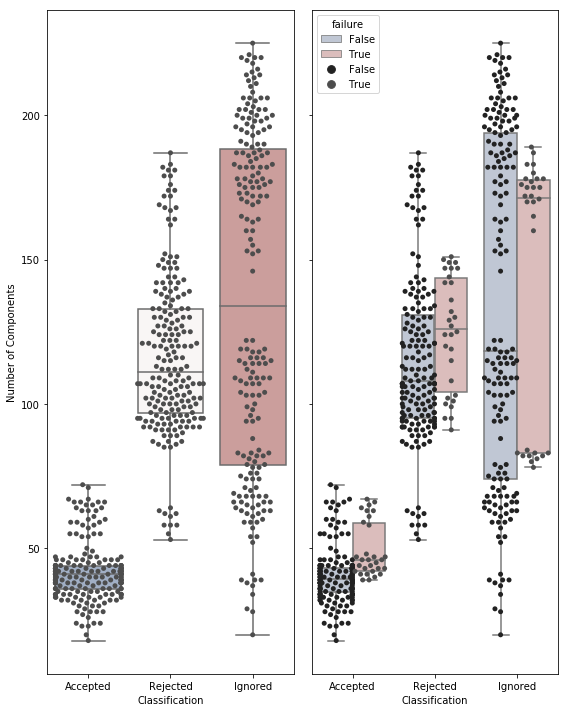

In [9]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[0])

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", data=clf_df,
              size=5, color=".3", linewidth=0, ax=axes[0])

sns.boxplot(x="classification", y="n components", data=clf_df,
            whis="range", palette="vlag", ax=axes[1], hue='failure')

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", data=clf_df,
              size=5, color=".3", linewidth=0, ax=axes[1], hue='failure', dodge=True)

axes[0].set_ylabel('Number of Components')
axes[0].set_xlabel('Classification')
axes[1].set_xlabel('Classification')
axes[1].set_ylabel('')
axes[0].set_xticklabels([l.get_text().title() for l in axes[0].get_xticklabels()])

fig.tight_layout()
fig.show()

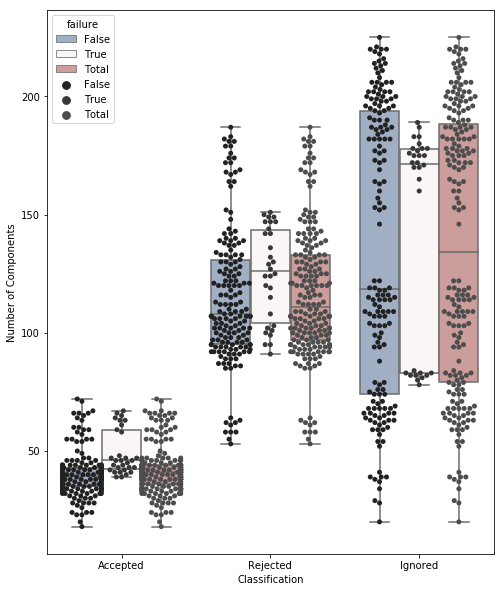

In [10]:
#sns.swarmplot(x='classification', y='n components', data=clf_df)
fig, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(x="classification", y="n components", data=df2,
            whis="range", palette="vlag", hue='failure')

# Add in points to show each observation
sns.swarmplot(x="classification", y="n components", hue='failure', data=df2,
              size=5, color=".3", linewidth=0, dodge=True)

ax.set_ylabel('Number of Components')
ax.set_xlabel('Classification')
ax.set_xticklabels([l.get_text().title() for l in ax.get_xticklabels()])
fig.show()